In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def spin_init(L,alinged=False):
    if alinged==False:
        lattice= np.random.choice((-1,1),size=(L,L,L)).astype(np.int32)

    if alinged==True:
        lattice=np.ones((L,L,L),dtype=np.int32)
    return lattice

In [3]:
# calculation of magnetization of the lattice
def magnetization(lattice,L):
    return np.sum(lattice)

In [4]:
def PBC(ind,L):
    """applies to index+1, to get the first element when index==L-1"""
    if ind == L-1:
        return 0
    else:
        return ind+1

In [5]:
def energy_site(lattice,L,i,j,k):
    '''
    calculation of interaction energy of each spin and total lattice energy
    '''
    #print ('we selected: ',lattice[i,j,k])
    #print (lattice[i-1,j,k] , lattice[PBC(i,L),j,k] , lattice[i,j-1,k] , lattice[i,PBC(j,L),k] , lattice[i,j,k-1] , lattice[i,j,PBC(k,L)]
    return lattice[i,j,k]*(lattice[i-1,j,k]+lattice[PBC(i,L),j,k]+lattice[i,j-1,k]+lattice[i,PBC(j,L),k]+lattice[i,j,k-1]+lattice[i,j,PBC(k,L)])

In [6]:
def energy_total(lattice,L):
    sum=0
    for i in range(L):
        for j in range(L):
            for k in range(L):
                sum-=energy_site(lattice,L,i,j,k) # -ve sign due to -J (ferromagnetic) in the hamitonian
    
    return sum/2 # correct for overcounting due to overlapping

In [7]:
# determine if a spin is flipped according to monte-carlo rules
def flip(lattice,L,T):
    for i in range(L):
        for j in range(L):
            for k in range(L):
                if energy_site(lattice,L,i,j,k)<0:
                    lattice[i][j][k]=-lattice[i][j][k]
                else:
                    if np.e**(-2*energy_site(lattice,L,i,j,k)/T)>np.random.uniform(0,1):
                        lattice[i][j][k]=-lattice[i][j][k]

In [8]:
# the main calculation routine to calculate the values
def main(lattice,L,N_run,T):
    M=0
    m=0
    M_sq=0
    E=0
    e=0
    E_sq=0
    
    ### stepping only lattice; no data sampling #####
    for k in range (N_ss):
        flip(lattice,L,T)

    count = 0
    for k in range (N_ss,N_run):
        flip(lattice,L,T)
        m=np.sum(lattice) #magnetization(lattice,L)
        M+=m
        M_sq+=m**2
        e=energy_total(lattice,L)
        E+=e
        E_sq+=e**2

        fname = '{:.2f}i{}.npy'.format(round(T,2),count)
        np.save(fname,lattice)
        count += 1
    
    M_mean=M/(N_run-N_ss)
    M_var=M_sq/(N_run-N_ss)-M_mean**2
    E_mean=E/(N_run-N_ss)
    E_var=E_sq/(N_run-N_ss)-E_mean**2
    C=E_var/T**2/L**3
    Chi=M_var/T/L**3

    return T,M_mean/L**3,E_mean/L**3,C,Chi # temporary take out lattice, which is global

In [9]:
## set your parameters here ##############
L=10;          ###=10  for trouble shooting; 50   for production run
N_run=10;     ###=100 for trouble shooting; 2000 for production run
fracN_ss=0.43   ### = 0.5 default. Must be a fractional number >=0 && < 1.
DeltaT=0.1     ###=1.0 for trouble shooting; 0.05 for production run
Tini=0.000;Tlast=5.0;  #default: Tini=0.0; Tlast=5.0
## end of set your parameters here ##############

### initialization ####
lattice = spin_init(L,alinged=True)
N_ss = int(fracN_ss*N_run);   ### step at which sampling of data begins
T_range = np.arange(Tini,Tlast+DeltaT,DeltaT)
sample_size = (N_run-N_ss)*T_range.shape[0]
ctn = np.zeros((T_range.shape[0],5),dtype=np.float32)
Tc = 4.5
#######################

In [10]:
import os,shutil
from time import localtime,mktime,strftime
from datetime import timedelta

In [11]:
cwd = '/home/junkai/3D_v1.1'
os.chdir(cwd)
data_dir = os.path.join(cwd,'data' + strftime('%Y%m%d',localtime()))

if os.path.isdir(data_dir):
    shutil.rmtree(data_dir)
    os.mkdir(data_dir)
else:
    os.mkdir(data_dir)

In [12]:
# making train dir
train_dir = os.path.join(data_dir,'train')

if os.path.isdir(train_dir):
    shutil.rmtree(train_dir)
    os.mkdir(train_dir)
else:
    os.mkdir(train_dir)

In [13]:
# print informations
print(20*'=',' Sampling Summary','='*20)
print('Lattice shape = ',lattice.shape)
print('Temperature range = ',(Tini,Tlast),',at DeltaT = ',DeltaT)
print ('total run per temperature= ',N_run)
print ('runs before sampling = ',N_ss)
print ('sampling runs per temperature = ',N_run-int(fracN_ss*N_run))
print ('total number of temperature batchs = ',T_range.shape[0])
print ('total sample size = ',sample_size)
print(20*'=',' end of Summary ','='*20)
print('\n')

====================  Sampling Summary ====================
Lattice shape =  (10, 10, 10)
Temperature range =  (0.0, 5.0) ,at DeltaT =  0.1
total run per temperature=  10
runs before sampling =  4
sampling runs per temperature =  6
total number of temperature batchs =  51
total sample size =  306
====================  end of Summary  ====================




In [14]:
### begin calculation ##########
print(20*'=',' Sampling in progress ','='*20)
os.chdir(train_dir)

batch = 0
for T in T_range:
    print("T =",T)
    ctn[batch][0],ctn[batch][1],ctn[batch][2],ctn[batch][3],ctn[batch][4]=main(lattice,L,N_run,T)
    batch +=1

print(20*'=',' end of Sampling ','='*20)
print('\n')

====================  Sampling in progress  ====================
T= 0.0


/share/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/share/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/share/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in double_scalars
/share/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars


T= 0.1
T= 0.2
T= 0.30000000000000004
T= 0.4
T= 0.5
T= 0.6000000000000001
T= 0.7000000000000001
T= 0.8
T= 0.9
T= 1.0
T= 1.1
T= 1.2000000000000002
T= 1.3
T= 1.4000000000000001
T= 1.5
T= 1.6
T= 1.7000000000000002
T= 1.8
T= 1.9000000000000001
T= 2.0
T= 2.1
T= 2.2
T= 2.3000000000000003
T= 2.4000000000000004
T= 2.5
T= 2.6
T= 2.7
T= 2.8000000000000003
T= 2.9000000000000004
T= 3.0
T= 3.1
T= 3.2
T= 3.3000000000000003
T= 3.4000000000000004
T= 3.5
T= 3.6
T= 3.7
T= 3.8000000000000003
T= 3.9000000000000004
T= 4.0
T= 4.1000000000000005
T= 4.2
T= 4.3
T= 4.4
T= 4.5
T= 4.6000000000000005
T= 4.7
T= 4.800000000000001
T= 4.9
T= 5.0
====================  end of Sampling  ====================




# generate file list

In [15]:
os.chdir(data_dir)

file_list = []
for root,dirs,files in os.walk(train_dir):
    for file in files:
        file_list.append(file)
        
#print(len(file_list))

In [16]:
labels_temp = []
for i in file_list:
    ans = float(i.split('i')[0])
    labels_temp.append(ans)
    
len(labels_temp)
labels_temp = np.asarray(labels_temp)

In [17]:
labels = np.zeros_like(labels_temp)
Tc = 2.269
for i in range(labels_temp.shape[0]):
    if labels_temp[i] < Tc:
        labels[i] = 1
    if labels_temp[i] > Tc:
        labels[i] = 0

In [18]:
print(20*'=',' Building train datasets ','='*20)

from sklearn.model_selection import train_test_split
test_size = 0.5
x_train, x_test, y_train, y_test = train_test_split(file_list, labels, test_size=test_size, random_state=42)

fname = os.path.join(data_dir,'train_dataset.npz')
np.savez(fname , x_train=x_train,x_test=x_test,y_train=y_train,y_test=y_test)
print('dataset saved as: ', fname)
print('with labels: ',np.load(fname).files)
print('shape of x_train: ',np.shape(x_train))
print('shape of y_train: ',np.shape(y_train))
print('test split: ', test_size)
print('note: x is a list of referenced data filenames. \nFor training, please build pipeline that take referenced files into the NN.\n')

fname = os.path.join(data_dir,'run_data.txt')
np.savetxt(fname,ctn,delimiter=' ',header='L='+str(L)+' N_run='+str(N_run)+'; T M E C Chi')

print('run data saved as {} \n'.format(fname))
print(20*'=',' end of train dataset preparation ','='*20)
print('\n')

====================  Building train datasets  ====================
dataset saved as:  /home/junkai/3D_v1.1/data20200813/train_dataset.npz
with labels:  ['x_train', 'x_test', 'y_train', 'y_test']
shape of x_train:  (153,)
shape of y_train:  (153,)
test split:  0.5
note: x is a list of referenced data filenames. 
For training, please build pipeline that take referenced files into the NN.

run data saved as /home/junkai/3D_v1.1/data20200813/run_data.txt 

====================  end of train dataset preparation  ====================




# visualization

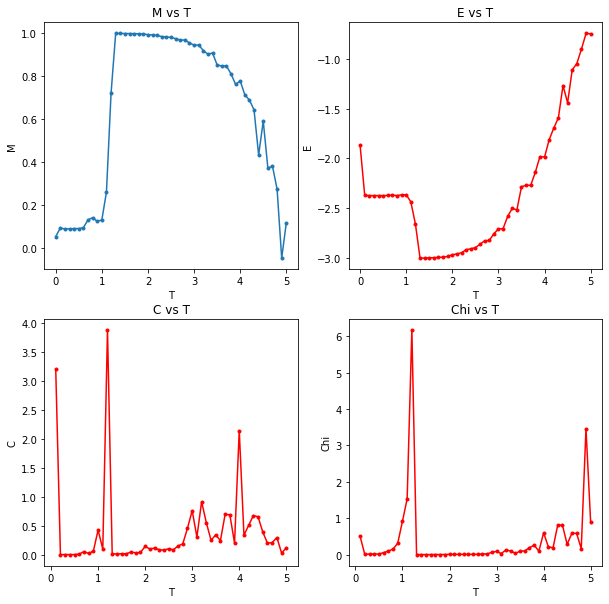

In [19]:
# visualization
T=np.ndarray.flatten(np.hsplit(ctn,5)[0])
M=np.ndarray.flatten(np.hsplit(ctn,5)[1])
E=np.ndarray.flatten(np.hsplit(ctn,5)[2])
C=np.ndarray.flatten(np.hsplit(ctn,5)[3])
Chi=np.ndarray.flatten(np.hsplit(ctn,5)[4])
### end of post processing output

### visualisation
fig=plt.figure(figsize=(10,10))
ax1=plt.subplot(2,2,1)
ax1.plot(T,M,'.-')
ax1.set_title("M vs T")
ax1.set_xlabel("T")
ax1.set_ylabel("M")

ax2=plt.subplot(2,2,2)
ax2.plot(T,E,'.-r')
ax2.set_title("E vs T")
ax2.set_xlabel("T")
ax2.set_ylabel("E")        

ax3=plt.subplot(2,2,3)
ax3.plot(T,C,'.-r')
ax3.set_title("C vs T")
ax3.set_xlabel("T")
ax3.set_ylabel("C")        

ax3=plt.subplot(2,2,4)
ax3.plot(T,Chi,'.-r')
ax3.set_title("Chi vs T")
ax3.set_xlabel("T")
ax3.set_ylabel("Chi") 

plt.show()

# under test !!!

In [ ]:
# record time elapsed
startime = localtime()

# when the programm runs

endtime = localtime()
duration = str(timedelta(seconds=mktime(endtime) - mktime(startime)))
print('code started on :',strftime('%x %X',startime),'\ncode ended on :',strftime('%x %X',endtime),'\ntime elapsed :',duration)

In [1]:
# check run status
import os
cwd = '/home/junkai/3D_v1.1/data20200814'

'''count = 0
for i,j,files in os.walk(cwd):
    for file in files:
        count+=1

print(count)'''

files = [i for i in os.walk(cwd)][1][2]
print(len(files),files[-1])

60500 6.00i499.npy
